In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import pickle
import pyspark
import nltk
nltk.download('punkt')
import itertools
import string
import os
import re
import math
from scipy.spatial import distance_matrix
import timeit
import scipy.sparse as sparse
from scipy.sparse.linalg import svds, eigs

[nltk_data] Downloading package punkt to /Users/ontheroad/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
data = np.float64(np.load('/Users/ontheroad/Desktop/cs25025/hw2/MNIST.npy'))
## (70000,784)
data = data/255
#data = data[:1000,]
## each component now lies in [0,1] instead of [0,255]

In [4]:
labels = np.float32(np.load('/Users/ontheroad/Desktop/cs25025/hw2/MNIST_labels.npy'))
## (70000,)

In [5]:
## divide the data into 60% training, 20% development, 20% test
l_tr = int(data.shape[0]*0.6)
l_de = int(data.shape[0]*0.2)
l_te = int(data.shape[0]*0.2)

tr_data = data[:l_tr,]
de_data = data[l_tr:l_tr+l_de,]
te_data = data[-l_te:,]

tr_labels = labels[:l_tr]
de_labels = labels[l_tr:l_de+l_tr]
te_labels = labels[-l_te:]


In [16]:
def plot_digit(X, center = None, index =None):
    #num = X.shape[0]
    #plt.figure(figsize=(ncols*2, nrows*2))
    %matplotlib inline

    if isinstance(X[0],float):
        #nrows = 1
        #ncols = 1
        subset = X     
        plt.subplot(1, 1, 1)
        plt.imshow(subset.reshape((28,28)), cmap='gray')
        if center == True:
            plt.title("Center for kmeans cluster" + str(index))
        plt.axis('off')
        plt.show()
        
    else: 
        nrows = 4
        ncols = 5
        subset = X[:20,]
        for i in range(nrows*ncols):
            plt.subplot(nrows, ncols, i+1)
            plt.imshow(subset[i].reshape((28,28)), cmap='gray')
            plt.axis('off')
    
        plt.axis('off')
        plt.show()

Part1: PCA

    (a) Extract Principal Component

In [68]:
center = np.mean(tr_data, axis = 0)

In [69]:
## centered training data
X = tr_data - center

In [70]:

## covariance matrix
S = np.matmul(np.transpose(X),X)/X.shape[0]

In [71]:
from numpy import linalg as LA
w,v = LA.eigh(S)
## w[i] is the ith eigenvalue
## v[:,i] is the ith eigenvector

In [72]:
#plt.plot(w)

In [73]:
## now take the top 10 component and use XVVT to replace X
# reverse w, v and it is in increasing order
w = w[:-1]
v = v[:,::-1]
v_10 = v[:,:10]

X_10 = np.dot(v_10,np.transpose(v_10))

In [74]:
X_10 = np.dot(X,X_10)

In [75]:
X_10 = X_10 + center
## remember to add back the center

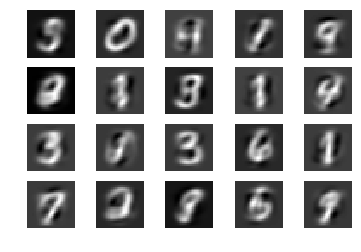

In [76]:
plot_digit(X_10)
#X_10.shape[0]


    (b) Plot Variance

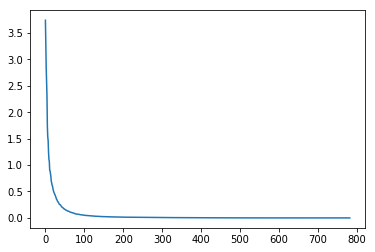

In [77]:
plt.plot(w[::-1])

    (c)Dimension Reduction

In [80]:
## pick one data point for testing
te1 = te_data[9]

In [81]:
te1_c = te1 - center

In [82]:
#te1_pr = np.linalg.lstsq(v_10, te1_c)[0]
te1_pr = np.dot(np.transpose(v_10), te1_c)

In [85]:
te1_new = np.dot(v_10,te1_pr) + center 

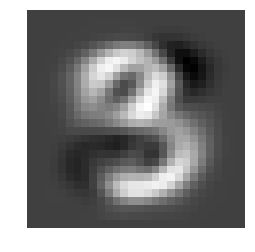

In [86]:
## this is the plot of the test number reconstructed from reduced dimension
plot_digit(te1_new)

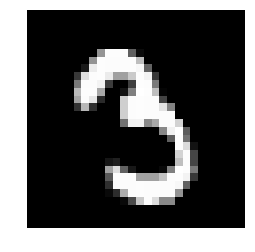

In [87]:
## as comparison, the original plot
plot_digit(te1)

In [88]:
##########################MORE ANALYSIS and experiment

In [91]:
## now package everything into a function
def reduced_digit(m,data,d_index):
    ### do PCA and generate the new base
    ## centering data
    center = np.mean(data,axis = 0)
    X = data - center
    ## compute covariance matrix
    S = np.matmul(np.transpose(X),X)/X.shape[0]
    ## decompose cov matrix
    from numpy import linalg as LA
    w,v = LA.eigh(S)
    w = w[:-1]
    v = v[:,::-1]
    v_m = v[:,:m]
    
    ## reconstruct data
    #X_m = np.dot(v_m,np.transpose(v_m))
    #X_m = np.dot(X,X_m)
    
    ## add back the center and plot
    #X_m = X + center   
    #plot_digit(X_10)
    
    ## draw a test digit from data, center, project, and reconstruct
    td = data[d_index]
    td_c = td - center
   # td_pr = np.linalg.lstsq(v_m, td_c)[0]
    td_pr = np.dot(np.transpose(v_m), td_c)
    td_new = np.dot(v_m,td_pr) + center 
    
    plot_digit(td_new)
    plot_digit(td)
    

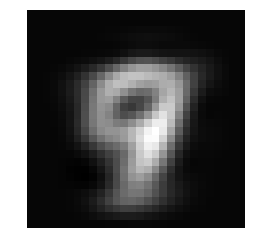

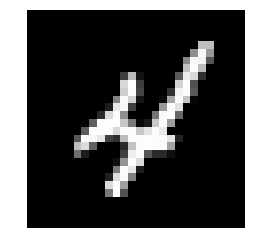

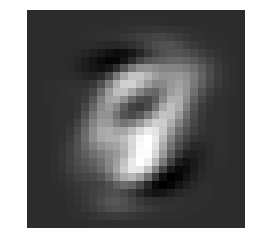

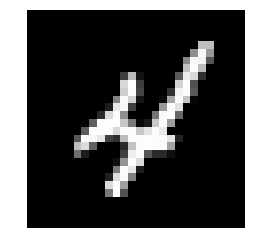

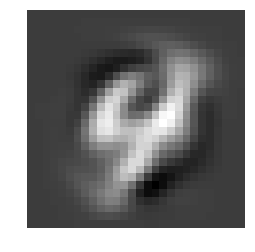

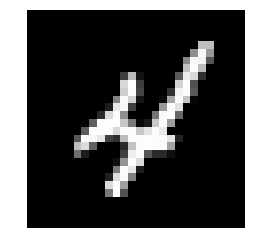

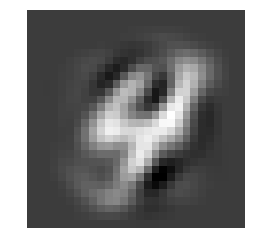

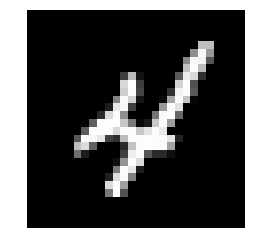

[None, None, None, None]

In [94]:
[reduced_digit(k,tr_data,9) for k in range(2,18,4)]

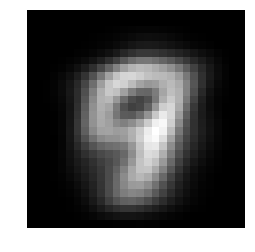

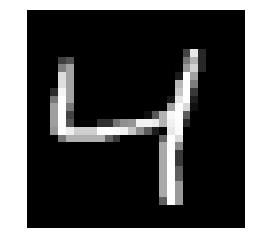

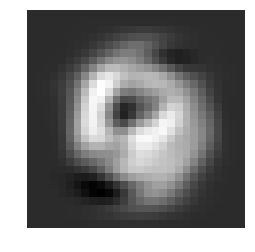

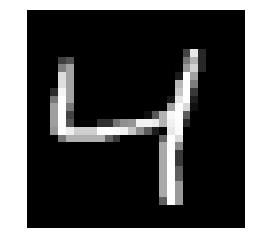

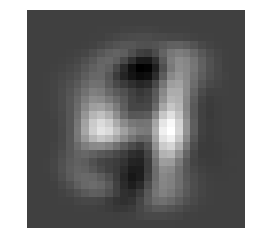

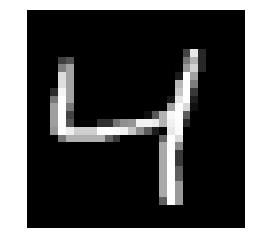

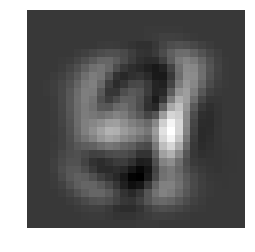

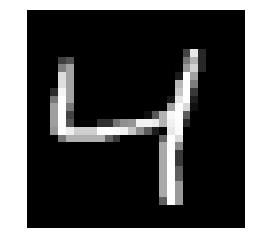

[None, None, None, None]

In [101]:
[reduced_digit(k,tr_data,2) for k in range(2,18,4)]

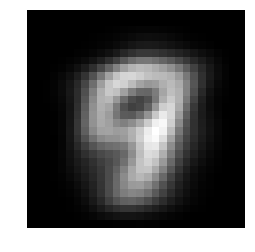

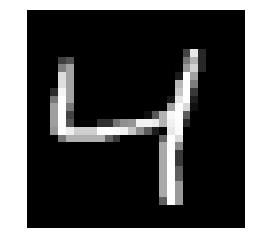

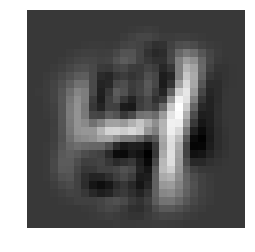

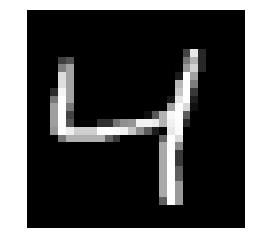

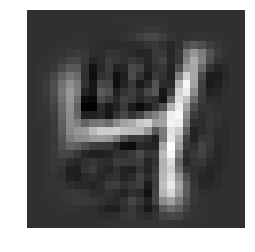

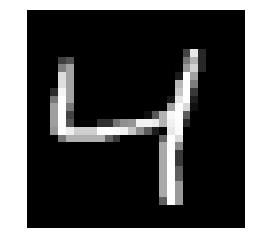

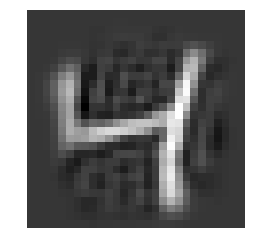

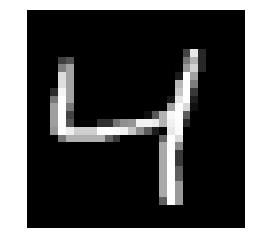

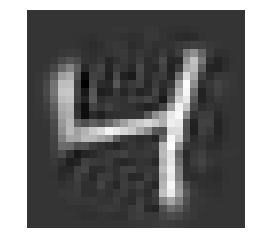

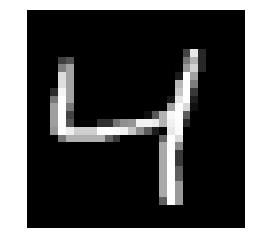

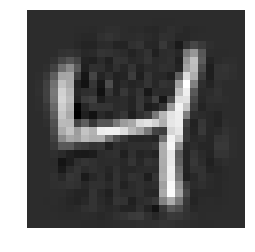

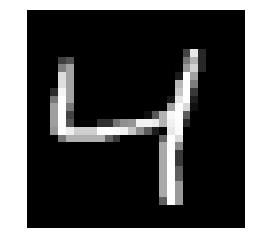

[None, None, None, None, None, None]

In [100]:
[reduced_digit(k,tr_data,2) for k in range(2,240,40)]

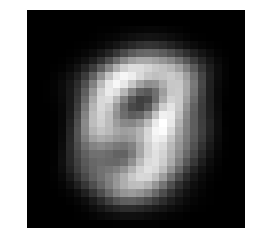

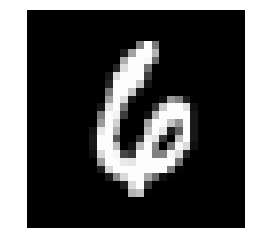

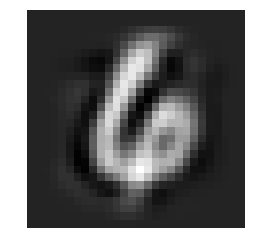

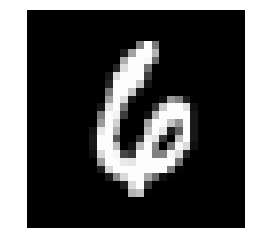

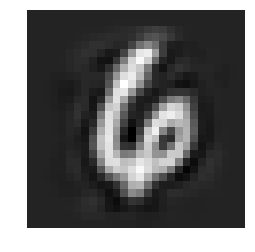

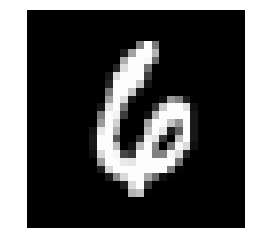

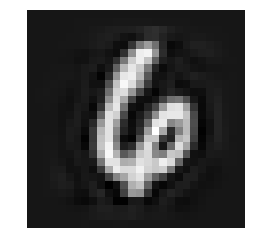

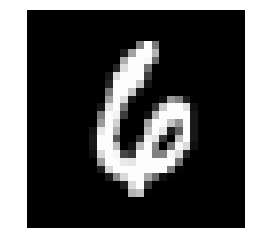

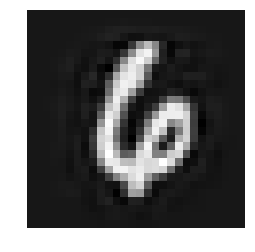

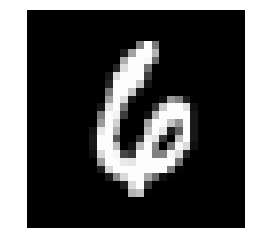

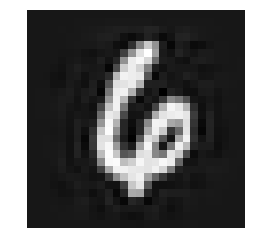

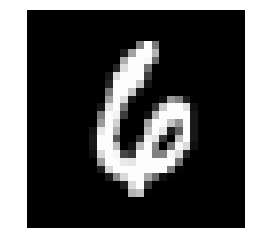

[None, None, None, None, None, None]

In [99]:
[reduced_digit(k,tr_data,39) for k in range(2,240,40)]

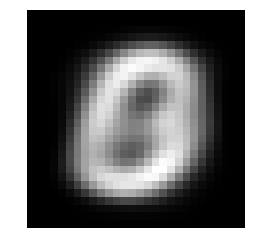

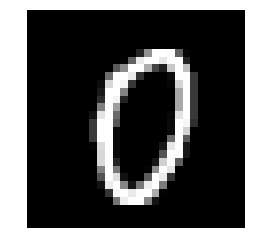

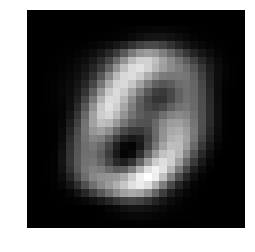

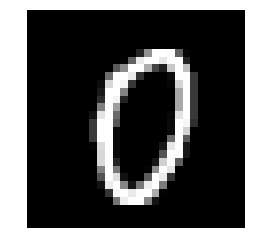

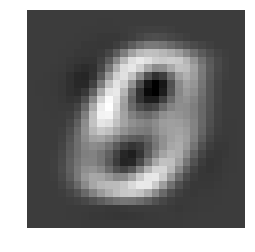

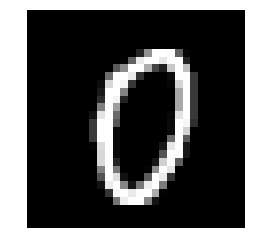

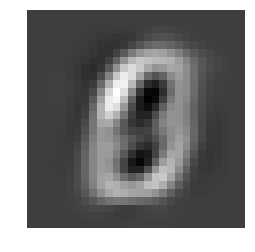

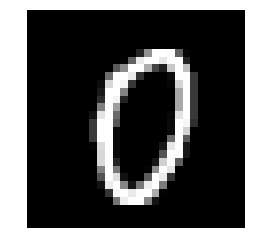

[None, None, None, None]

In [97]:
[reduced_digit(k,tr_data,1000) for k in range(2,18,4)]

Analysis:
In m principle component analysis: <br>
On some cases PCA can achieve good results with relatively few PCs (<20): when m is small, the image captures crude shape of the digits (the donut shape of 4, for example), but it has much noise; when m gets larger (>=10), the image begins to distinguish itself from other digits and shows finer details at the edges. 
The top principle component captures the overall shape of an image. <br>
However, on some cases PCA needs many PCs to do well, particularly in the "4" case, which I did two sets of PCAs. The first top 18 does not show the shape of the image; it only works when I use 240 PCs. This might be due to the fact that the image is more spread out, thus small losses of information might cause big changes in the overall shapes. 

Part2: K-MEANS

In [6]:
## here I am applying kmeans to training data
from sklearn.cluster import KMeans
## number of cluster is 10
n_digits = 10
model = KMeans(n_clusters=n_digits)
tr_clust = model.fit(tr_data)
y_means = tr_clust.predict(tr_data)
centers = tr_clust.cluster_centers_

In [341]:
## below i am showing the distribution, center and some other samples from the graph

In [59]:
y_means = y_means.astype(int)
tr_labels = tr_labels.astype(int)
#labeled_cluster = pd.DataFrame(y_means,index = tr_labels)
labeled_cluster = pd.DataFrame(tr_labels,index = y_means)

In [60]:
digit_labeled_group = [labeled_cluster.loc[x] for x in range(10)]

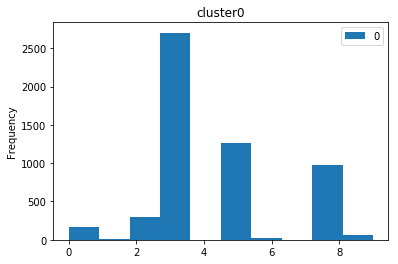

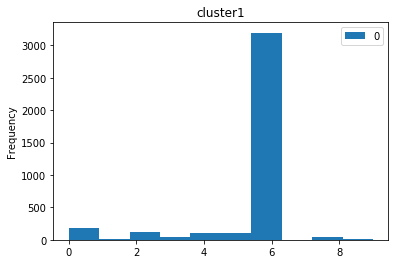

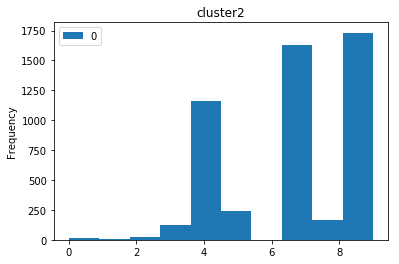

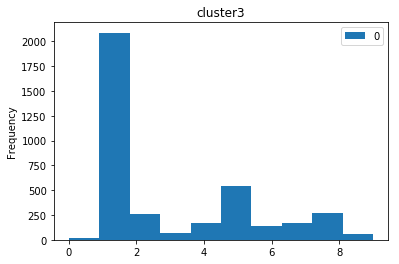

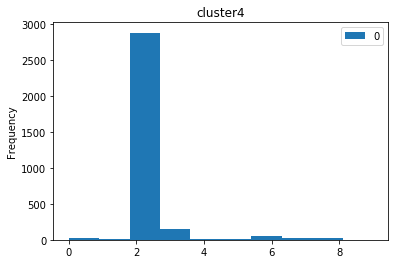

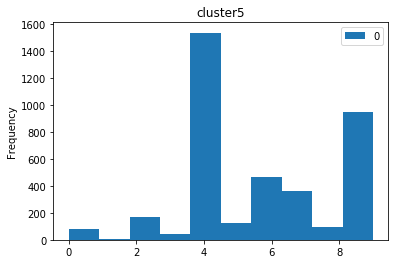

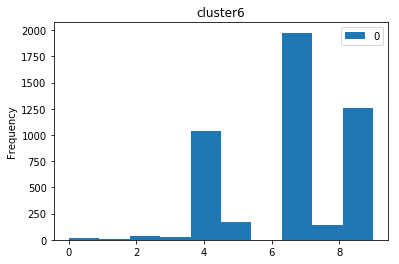

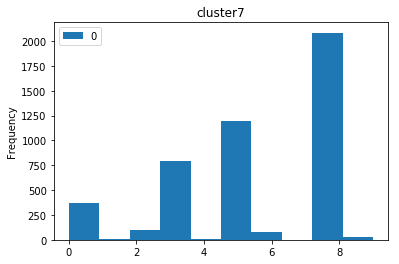

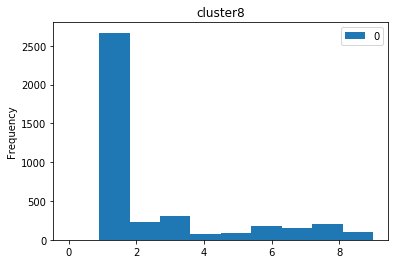

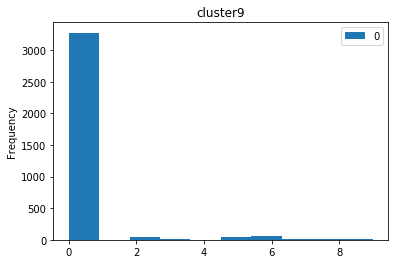

In [71]:
## below is the plot of the distribution of digits (labels) among the 10 clusters
[digit_labeled_group[i].plot(kind='hist',title = 'cluster'+str(i)) for i in range(10)]

In [62]:
from collections import Counter
#associations = [Counter(digit_labeled_group[0].iloc[:,0]).most_common(1)[0][0] for x in Counter(digit_labeled_group]
associations = [Counter(x.iloc[:,0]).most_common(1)[0][0] for x in digit_labeled_group]
#associations = [int(x) for x in associations]

In [63]:
len(digit_labeled_group)

10

In [64]:
associations

[3, 6, 9, 1, 2, 4, 7, 8, 1, 0]

In [33]:
labels = [str(i)+"~"+str(associations[i])for i in range(10)]


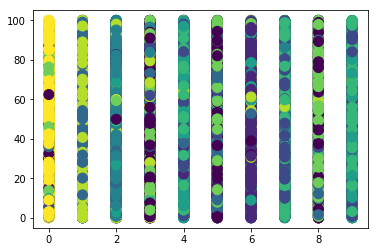

In [13]:
## below plot how the labled (x-axix)didits are distributed among clusters (in different colors)
## assocoi
y = 100*np.random.uniform(0,1,tr_labels.shape[0])
plt.scatter(tr_labels,y,c=y_means, s= 100)


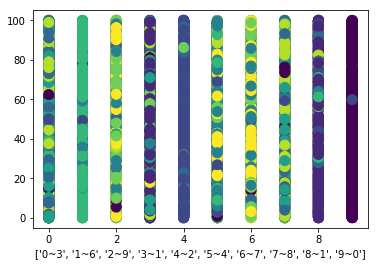

In [65]:
## below plot how the kmeans clusters are distributed according to their digits (in different colors)
#y = 100*np.random.uniform(0,1,tr_labels.shape[0])
# majority-labels are added below X -axis
plt.scatter(y_means,y,c=tr_labels, s= 100)
plt.xlabel(labels)
plt.show()
############add associaioton!

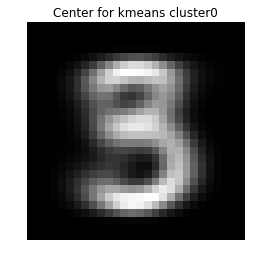

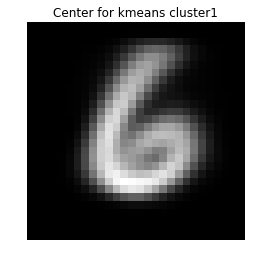

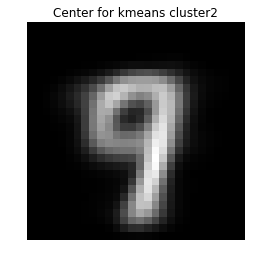

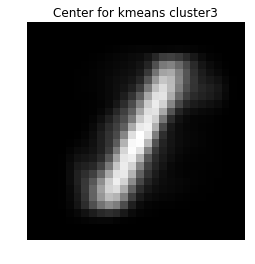

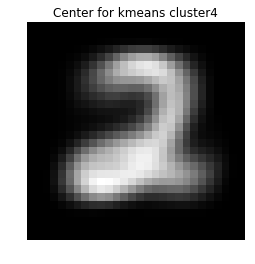

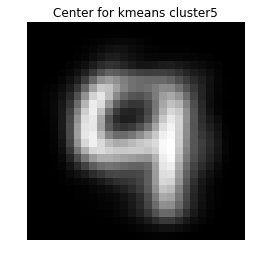

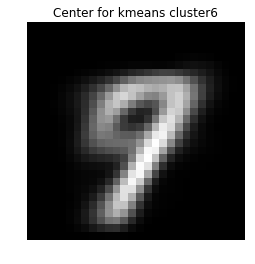

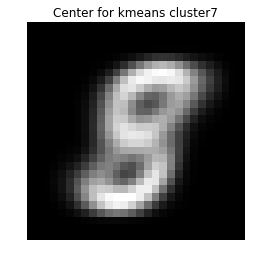

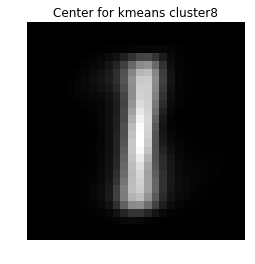

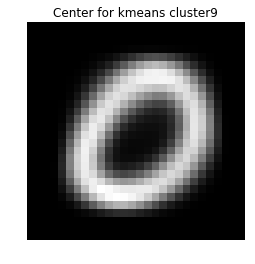

[None, None, None, None, None, None, None, None, None, None]

In [72]:
## below show the center for the 10 clusters; 

[plot_digit(centers[i],True,i) for i in range(10) ]

In [19]:
#show the sample of each cluster

clustered_samples = pd.DataFrame(tr_data, index = y_means)

In [20]:
clustered_samples = [clustered_samples.loc[clustered_samples.index == i,::] for i in range(10)]

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  # This is added back by InteractiveShellApp.init_path()


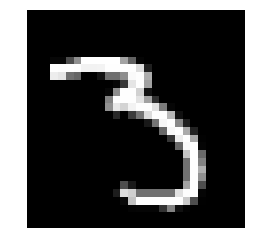

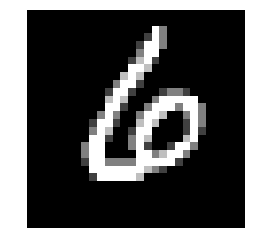

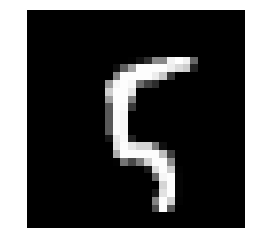

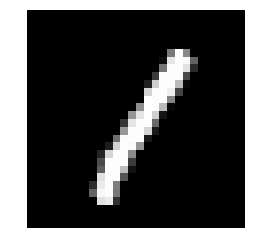

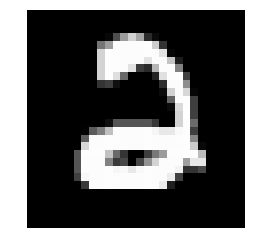

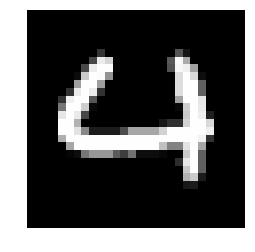

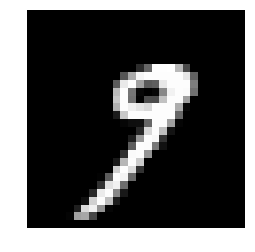

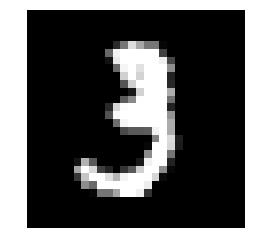

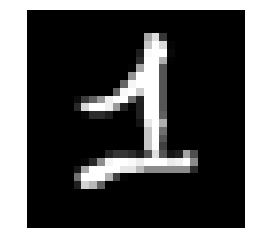

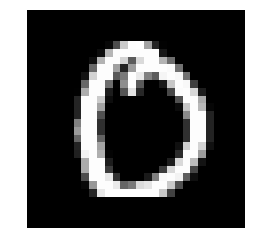

[None, None, None, None, None, None, None, None, None, None]

In [21]:
## below are the random samples from cluster 0-9
import random
rd = [random.randint(0,9) for i in range(10)]
[plot_digit(clustered_samples[i].iloc[rd[i],:]) for i in range(10)]

Comment on the results:<br>
As can be seen, the cluster 6 and 5, corresponding to majority 4 and 7 have many 9s in them. So the KMeans find it hard to distinguish numbers that have similar shapes, like 4,9,7. The overall similarity in shape may give enough information for the kmeans to cluster them together. 


# Analysis
From the 10 centers, We can see there is no appearance of 7, but with 2 ones (in cluster 2 and 8), with the first one more vertical and the second one more glided. This corresponds to the fact that in the kmeans plot above, the component of kmeans cluster 2 and 8 are the same two types. This also shows that the cluster respects the absolute spatial position of the pixels, instead of the relative position (otherwise it should see that vertical one and glided one the not that different)

Part 3: Spectral Clustering

In [130]:
## data selection
spec_data = tr_data[:1000]
spec_label = tr_labels[:1000]

In [131]:
## compute weight matrix W = exp(-gamma*|xi-xj|^2)

In [132]:
W = sklearn.metrics.pairwise.rbf_kernel(spec_data, Y=None, gamma=None)

In [133]:
W.shape

(1000, 1000)

In [134]:
## compute graph laplacian
d = W.sum(axis = 0)
d_inv_sq = 1/np.sqrt(d)
D = np.diag(d)
D_inv_sq = np.diag(d_inv_sq)

In [135]:
#L = np.identity(D.shape[0]) - D_inv_sq*W*D_inv_sq
L = np.identity(D.shape[0]) - D_inv_sq.dot(W).dot(D_inv_sq)
#L = np.identity(D.shape[0]) - np.matmul(np.matmul(D_inv_sq,W),D_inv_sq)

In [136]:
## compute the eigenvectors of L and take the smallest r eigenvectors
from numpy import linalg as LA
spec_w,spec_v = LA.eigh(L)

In [137]:
spec_v2 = spec_v[:,1:3]
spec_v3 = spec_v[:,1:4]

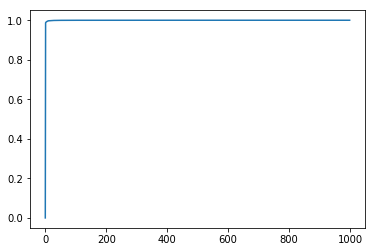

In [138]:
plt.plot(spec_w)

In [139]:
## DO Kmeans
## here I am applying kmeans to training data
from sklearn.cluster import KMeans
## number of cluster is 10
n_digits = 10
model2 = KMeans(n_clusters=n_digits)
spec_clust_2 = model.fit(spec_v2)
spec_means_2 = spec_clust_2.predict(spec_v2)
spec_centers_2 = spec_clust_2.cluster_centers_

#n_digits = 10
model3 = KMeans(n_clusters=n_digits)
spec_clust_3 = model.fit(spec_v3)
spec_means_3 = spec_clust_3.predict(spec_v3)
spec_centers_3 = spec_clust_3.cluster_centers_

In [140]:
spec_lab_clu2 = pd.DataFrame(spec_means_2, index =spec_label)
spec_lab_clu3 = pd.DataFrame(spec_means_3, index =spec_label)
spec_labeled_group2 = [spec_lab_clu2.loc[x] for x in range(10)]
spec_labeled_group3 = [spec_lab_clu3.loc[x] for x in range(10)]


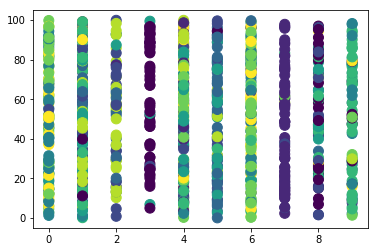

In [141]:
## below plot how the kmeans clusters are distributed according to their digits (in different colors)
y = 100*np.random.uniform(0,1,spec_label.shape[0])
plt.scatter(spec_means_2,y,c=spec_label, s= 100)
#plt.xlabel("kmeans clusters")
#labels = ["cluster "+str(i)+"~"+" majority "+ str(associations[i])for i in range(10)]
#plt.xticks(y_means, labels, rotation='vertical')
#plt.margins = [0,10]
plt.show()


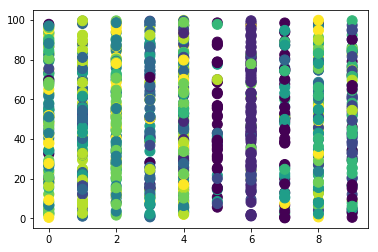

In [142]:
## below plot how the kmeans clusters are distributed according to their digits (in different colors)
y = 100*np.random.uniform(0,1,spec_label.shape[0])
plt.scatter(spec_means_3,y,c=spec_label, s= 100)
#plt.xlabel("kmeans clusters")
#labels = ["cluster "+str(i)+"~"+" majority "+ str(associations[i])for i in range(10)]
#plt.xticks(y_means, labels, rotation='vertical')
#plt.margins = [0,10]
plt.show()

In [143]:
from collections import Counter
#associations = [Counter(digit_labeled_group[0].iloc[:,0]).most_common(1)[0][0] for x in Counter(digit_labeled_group]
spec_associations2 = [Counter(x.iloc[:,0]).most_common(1)[0][0] for x in spec_labeled_group2]
spec_associations3 = [Counter(x.iloc[:,0]).most_common(1)[0][0] for x in spec_labeled_group3]


In [144]:
spec_associations2

[3, 7, 1, 5, 0, 1, 9, 6, 2, 6]

In [145]:
spec_associations3

[5, 6, 9, 3, 2, 8, 9, 2, 1, 2]

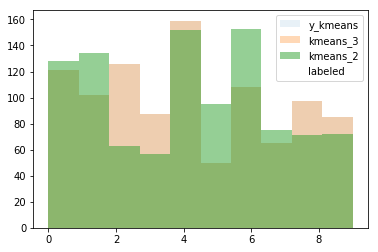

In [146]:
#bins = np.linspace(-10, 10, 100)
plt.hist(spec_means_3, alpha=0.1, label='y_kmeans')
plt.hist(spec_means_3, alpha=0.3, label='kmeans_3')
plt.hist(spec_means_2, alpha=0.5, label='kmeans_2')
plt.hist(spec_label, alpha=0., label='labeled')
plt.legend(loc='upper right')
plt.show()

Part 4: Classification

In [147]:
from sklearn.linear_model import LogisticRegression
lg = LogisticRegression(fit_intercept=True, C = 100000,penalty='l2',\
                       multi_class='multinomial',solver='lbfgs')

In [148]:
tr_lr = lg.fit(tr_data, tr_labels)

In [149]:
de_lr_means = tr_lr.predict(de_data)

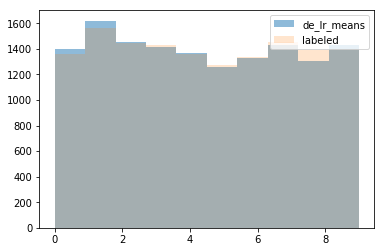

In [151]:

plt.hist(de_lr_means, alpha=0.5, label='de_lr_means')
plt.hist(de_labels, alpha=0.2, label='labeled')
plt.legend(loc='upper right')
plt.show()

In [152]:
## now calculate the error rate
error_de = de_lr_means - de_labels
num_error_rate = sum([int(x != 0) for x in error_de])
num_error_rate = num_error_rate/de_labels.shape[0]

In [154]:
num_error_rate

0.08807142857142858

The error rate for development is 0.08807142857142858

(b) plot error vs k

In [160]:
def error_vs_k(k,data_old,label_old,data_new,label_new):
    center_old = np.mean(data_old, axis = 0)
    X_old = data_old - center_old
    center_new = np.mean(data_new, axis = 0)
    X_new = data_new - center_new
    
   
        
    v_k = v[:,:k]
    alpha_new = np.matmul(X_new,v_k)
    alpha_old = np.matmul(X_old,v_k)
    tr_lr_pck = lg.fit(alpha_old, label_old)
    new_lr_means_pck = tr_lr_pck.predict(alpha_new)
    error_new_pck = new_lr_means_pck - label_new
    num_error_rate_pck = sum([int(x != 0) for x in error_new_pck])
    num_error_rate_pck = num_error_rate_pck/label_new.shape[0]
   # print(num_error_rate_pck)
    #print(k)
    return num_error_rate_pck
   # return (alpha_new,alpha_old,new_lr_means_pck)

In [161]:
error_vs_k(10,tr_data,tr_labels,de_data,de_labels)

0.21157142857142858

In [162]:
ks = [(i+1)*28 for i in range(28)]
error_k = [error_vs_k(k,tr_data,tr_labels,de_data,de_labels)\
           for k in ks]

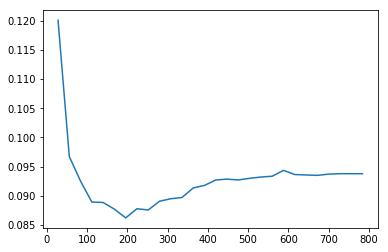

In [451]:
plt.plot(ks,error_k)

In [410]:
# We can see thw smallest value should be within [168,224]
## now perform a narrowed search for k
ks_narrow = [i for i in range(168,224,4)]

In [452]:
error_k_narrow = [error_vs_k(k,tr_data,tr_labels,de_data,de_labels)\
                  for k in ks_narrow]

(14000, 168)
0.08771428571428572
168
(14000, 172)
0.08757142857142858
172
(14000, 176)
0.0885
176
(14000, 180)
0.08785714285714286
180
(14000, 184)
0.08707142857142858
184
(14000, 188)
0.08671428571428572
188
(14000, 192)
0.08642857142857142
192
(14000, 196)
0.08621428571428572
196
(14000, 200)
0.08714285714285715
200
(14000, 204)
0.08742857142857142
204
(14000, 208)
0.08707142857142858
208
(14000, 212)
0.087
212
(14000, 216)
0.08707142857142858
216
(14000, 220)
0.087
220


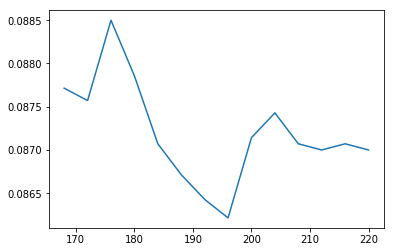

In [453]:
plt.plot(ks_narrow,error_k_narrow)
plt.xlabel = ks_narrow

In [418]:
## we observe that the smallest k is at 196
## now retrain with tr_data and de_data

By ploting error rate VS k (PC number), we can see error rate drops as k gets larger, showing more information captured by more PCs help cluster new data; then it rises relatively more slowly as k exceeds 196, showing the consequence of overfitting. 

(c) cross-validation

In [426]:
tr_de_data = np.concatenate((tr_data,de_data), axis=0)
tr_de_labels = np.concatenate((tr_labels,de_labels), axis=0)

tr_de_lr = lg.fit(tr_de_data, tr_de_labels)

In [427]:
te_lr_means = tr_de_lr.predict(te_data)

In [428]:
### below I compute the error rate when use raw data as a comparison
error_te = te_lr_means - te_labels
num_error_rate_te = sum([int(x != 0) for x in error_te])
num_error_rate_te = num_error_rate_te/te_labels.shape[0]
num_error_rate_te

0.06607142857142857

In [447]:
## Now I compute error rate when using top 196 pc
err_te_196 = error_vs_k(196,tr_de_data,tr_de_labels,te_data,te_labels)

(14000, 196)
0.068
196


In [448]:
## this is the error rate for 196_PC
err_te_196

0.068

When doing logistic regression using top 196 PCs, the error rate is 0.068, compared to 0.066 when done with raw data. The differences are relatively small, indicating that the dimension can be reduced from 784 to 196 without losing too much imformation conserning classification.